## Проверка того, что все работает нормально

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

from tqdm import tqdm

import timeit
import xgboost as xgb

Подготовка данных

In [7]:
column_names = 'label, lepton 1 pT, lepton 1 eta, lepton 1 phi, lepton 2 pT, lepton 2 eta, lepton 2 phi, missing energy magnitude, missing energy phi, MET_rel, axial MET, M_R, M_TR_2, R, MT2, S_R, M_Delta_R, dPhi_r_b, cos(theta_r1)'.split(', ')
data = pd.read_csv('../../../../data/SUSY.csv', header=None, names=column_names)

X_data = data.drop('label', 1)
X_data = StandardScaler().fit_transform(X_data)

labels = data["label"]

indx_train, indx_test = train_test_split(np.arange(len(labels), dtype='int32'), 
                                         stratify=labels, train_size=8e-2, test_size=2e-2, random_state=5)

y_train = labels[indx_train].reset_index(drop=True)
y_test = labels[indx_test].reset_index(drop=True)

X_train = X_data[indx_train]
X_test = X_data[indx_test]

In [10]:
X_good = X_train[np.where(y_train==0)[0]]
X_bad = X_train[np.where(y_train==1)[0]]

Чисто попробовать, что все правильно работает

In [22]:
frac = 0.25
if frac > 1:
    end_ind = X_bad.shape[0]
else:   
    end_ind = int(X_bad.shape[0] * frac)

XGBclassifier = xgb.sklearn.XGBClassifier(nthread=-1, seed=1,n_estimators=500)
#Train and time classifier
start_time = timeit.default_timer()

XGBclassifier.fit(np.concatenate((X_good, X_bad[:end_ind])), 
        np.concatenate((np.zeros((X_good.shape[0],1)), np.ones((end_ind,1)))).ravel())
run_time = timeit.default_timer() - start_time

#Make Predictions
y_pred = XGBclassifier.predict_proba(X_test)[:,1]

#Print Results
print("Model Accuray with all features: {:.2f}%".format(100*XGBclassifier.score(X_test, y_test)))
print("The AUC score with all features is {:.2f}".format(roc_auc_score(y_test,y_pred)))
print("Run time with all features: {:.2f} sec".format(run_time))

Model Accuray with all features: 75.34%
The AUC score with all features is 0.87
Run time with all features: 179.73 sec


/opt/conda/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [20]:
#Make Predictions
y_pred = XGBclassifier.predict_proba(X_test)[:,1]

#Print Results
print("Model Accuray with all features: {:.2f}%".format(100*XGBclassifier.score(X_test, y_test)))
print("The AUC score with all features is {:.2f}".format(roc_auc_score(y_test,y_pred)))
print("Run time with all features: {:.2f} sec".format(run_time))

Model Accuray with all features: 79.97%
The AUC score with all features is 0.87
Run time with all features: 1926.44 sec


/opt/conda/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ROC AUC = 0.87 => все нормально

In [9]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)
print(y_train[:3])
print(X_train[:3])

(400000, 18) (100000, 18)
(400000,) (100000,)
0    0.0
1    1.0
2    0.0
Name: label, dtype: float64
[[-0.48755867 -0.05609537 -1.45735499 -0.67104233 -0.3141311  -0.17533751
  -0.58360203  0.67027365 -0.2987083  -0.16641054 -0.75116262 -0.5479811
   0.30314609 -0.02420738 -0.74847251 -0.42300419  0.03320768  0.53455134]
 [-0.42587686 -0.15646528  1.60384477 -0.1837584  -1.45236318  0.58316912
   0.69490355 -0.10845304  1.45980105 -0.86159042 -0.23701411  0.59225695
   0.85596138  1.3318575  -0.04992907  1.2946766   0.61611362  0.5422526 ]
 [-0.71144096 -1.75277062  0.91867046 -0.38180142 -1.15781325 -0.06327793
  -0.81678314  1.32207671 -0.80553358  0.328672   -0.74866107 -1.00812799
  -0.66062375 -0.51147856 -0.86993087 -0.7317944  -1.11967402 -0.49409409]]


# Получение значений метрик

In [33]:
import time
from IPython import display

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets, mixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve
from itertools import cycle, islice
import h5py 
import shutil

import sys
sys.path.append('../../')

from evaluation import *
from tqdm import tqdm
np.random.seed(10)
%matplotlib inline

In [2]:
from sklearn.mixture import GaussianMixture

## Подготовим данные

In [3]:
import pandas as pd
#! wget -o  ../../datasets/ https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz
column_names = 'label, lepton 1 pT, lepton 1 eta, lepton 1 phi, lepton 2 pT, lepton 2 eta, lepton 2 phi, missing energy magnitude, missing energy phi, MET_rel, axial MET, M_R, M_TR_2, R, MT2, S_R, M_Delta_R, dPhi_r_b, cos(theta_r1)'.split(', ')
data = pd.read_csv('../../../../data/SUSY.csv', header=None, names=column_names)

In [4]:
data.head()

,label,lepton 1 pT,lepton 1 eta,lepton 1 phi,lepton 2 pT,lepton 2 eta,lepton 2 phi,missing energy magnitude,missing energy phi,MET_rel,axial MET,M_R,M_TR_2,R,MT2,S_R,M_Delta_R,dPhi_r_b,cos(theta_r1)
0,0.0,0.972861,0.653855,1.176225,1.157156,-1.739873,-0.874309,0.567765,-0.175000,0.810061,-0.252552,1.921887,0.889637,0.410772,1.145621,1.932632,0.994464,1.367815,0.040714
1,1.0,1.667973,0.064191,-1.225171,0.506102,-0.338939,1.672543,3.475464,-1.219136,0.012955,3.775174,1.045977,0.568051,0.481928,0.000000,0.448410,0.205356,1.321893,0.377584
2,1.0,0.444840,-0.134298,-0.709972,0.451719,-1.613871,-0.768661,1.219918,0.504026,1.831248,-0.431385,0.526283,0.941514,1.587535,2.024308,0.603498,1.562374,1.135454,0.180910
3,1.0,0.381256,-0.976145,0.693152,0.448959,0.891753,-0.677328,2.033060,1.533041,3.046260,-1.005285,0.569386,1.015211,1.582217,1.551914,0.761215,1.715464,1.492257,0.090719
4,1.0,1.309996,-0.690089,-0.676259,1.589283,-0.693326,0.622907,1.087562,-0.381742,0.589204,1.365479,1.179295,0.968218,0.728563,0.000000,1.083158,0.043429,1.154854,0.094859


In [5]:
data.shape

(5000000, 19)

Делим выборку на признаки и таргеты. Нормируем признаки.

$X_{new} = \frac{X - \mu}{\sigma}$

In [6]:
X_data = data.drop('label', 1)
X_data = StandardScaler().fit_transform(X_data)

labels = data["label"]

Разбиваем на train(8% от всех данных) и test(2%)

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
indx_train, indx_test = train_test_split(np.arange(len(labels), dtype='int32'), 
                                         stratify=labels, train_size=8e-2, test_size=2e-2, random_state=5)

In [9]:
y_train = labels[indx_train].reset_index(drop=True)
y_test = labels[indx_test].reset_index(drop=True)

X_train = X_data[indx_train]
X_test = X_data[indx_test]

Разбиваем объекты по классам

In [12]:
X_good = X_train[np.where(y_train==0)[0]]
X_bad = X_train[np.where(y_train==1)[0]]

In [13]:
X_good.shape, X_train.shape, X_data.shape

((216974, 18), (400000, 18), (5000000, 18))

Судя по размеру X_good, нельзя сказать, что второй класс - аномалия, поскольку классы сбалансированы

## Supervised

In [14]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score, average_precision_score

Реализуем функции для вычисления precision at recall и precision at 10

In [15]:
def p_at_10(y_test, y_pred, n=10):
    ind = np.argpartition(y_pred[:, 0], -n)[-n:]
    try:
        mean = np.mean(y_test[ind])
    except:
        mean = np.mean(y_test.iloc[ind])
    return mean

In [16]:
def p_at_10_un(y_test, y_pred, n=10):
    try:
        ind = np.argpartition(y_pred[:, 0], -n)[-n:]
    except:
        ind = np.argpartition(y_pred, -n)[-n:]
    try:
        mean = np.mean(y_test[ind])
    except:
        mean = np.mean(y_test.iloc[ind])
    return mean

In [17]:
def p_at_r(y_test, y_pred, x):
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    return max(precision[recall > x])

In [18]:
def _eval_p_at_rs(y_test, y_pred, frac, ours_p_at_r, descr):
    for recall in ours_p_at_r.keys():
        if descr in ours_p_at_r[recall]:
            # append the new number to the existing array at this slot
            ours_p_at_r[recall][descr].append((frac, p_at_r(y_test, y_pred, float(recall))))
        else:
            # create a new array in this slot
            ours_p_at_r[recall][descr] = [(frac, p_at_r(y_test, y_pred, float(recall)))]
            
def _eval_p_at_rs_flatten(y_test, y_pred, frac, ours_p_at_r, descr):
    for recall in ours_p_at_r.keys():
        ours_p_at_r[recall][descr] = (frac, p_at_r(y_test, y_pred, float(recall)))

Выберем классификаторы

In [19]:
classifiers_classic_sup = {
    "XGB_60": xgb.XGBClassifier(n_estimators=60, nthread=-1, seed=111),
    "XGB_200": xgb.XGBClassifier(n_estimators=200, nthread=-1, seed=111),
    "XGB_500": xgb.XGBClassifier(n_estimators=500, nthread=-1, seed=111),
    "XGB_1000": xgb.XGBClassifier(n_estimators=1000, nthread=-1, seed=111),
    "XGB_1500": xgb.XGBClassifier(n_estimators=1500, nthread=-1, seed=111),
}

In [63]:
supervised_pr_aucs = {}
supervised_roc_aucs = {}
supervised_p_at_10 = {}
supervised_p_at_r = {
    '0.8': {},
    '0.9': {}, 
    '0.95': {},
    '0.99': {},
}

Сохранение данных

In [25]:
import json

def dump(saved_dict, folder, name):
    dict_for_json = {k: {kk: list(vv) for kk, vv in v.items()} if isinstance(v, dict) else list(v) 
                     for k, v in saved_dict.items()}
    with open(os.path.join(folder, name + ".json"), 'w', encoding="utf-8") as file:
        # writing
        json.dump(dict_for_json, file, indent=4, ensure_ascii=False)
    del dict_for_json

In [41]:
def create_metrics_folder(metrics_path):
    try:
        last_folder_n = max(list(map(lambda name: int(name), 
                                     filter(lambda name: os.path.isdir(os.path.join(metrics_path, name)) 
                                            and name.isdecimal(), os.listdir(metrics_path)))))
    except:
        last_folder_n = 0
    new_folder = os.path.join(metrics_path, str(last_folder_n + 1))
    old_folder = os.path.join(metrics_path, str(last_folder_n))
    os.makedirs(new_folder)    
    return new_folder, old_folder

In [45]:
def dump_metrics(metrics_path):
    folder, old_folder = create_metrics_folder(metrics_path)
    print(folder)

    dump(supervised_pr_aucs, folder, "supervised_pr_aucs")
    dump(supervised_roc_aucs, folder, "supervised_roc_aucs")
    dump(supervised_p_at_10, folder, "supervised_p_at_10")
    dump(supervised_p_at_r, folder, "supervised_p_at_r")
    
    shutil.rmtree(old_folder, ignore_errors=True)
    

In [46]:
dump_metrics(metrics_path)

./metrics/xgb/2


Значения долей негативных примеров взял из Meeting minutes (29.03.2018)

In [64]:
fraction_of_negative_used = np.array([0.1, 0.5, 1, 5, 10, 25, 100]) / 100.
n_resplits = np.array([40, 35, 30, 25, 20, 10, 10])

Построение графика

In [65]:
def plot_for_comparison(dic, names, ylabel="PR AUC", y_lim=(0.3, 1.0)):
    plt.figure(figsize=(7, 7))
    for i, name in enumerate(names):
        x, y = list(map(list, zip(*dic[name])))
        plt.boxplot(x, y)
    
    plt.ylabel(ylabel)
    plt.ylim(y_lim)
    plt.xlabel("% of used anomalies")
    plt.xlim(0, 1)
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

/opt/conda/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


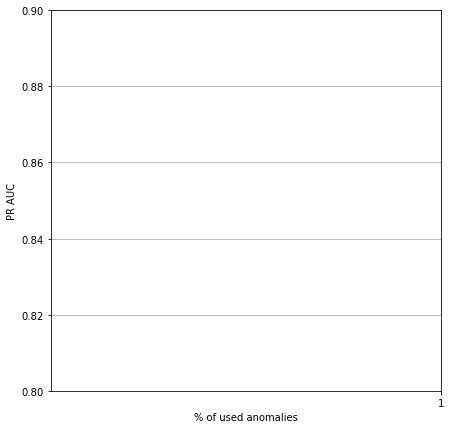

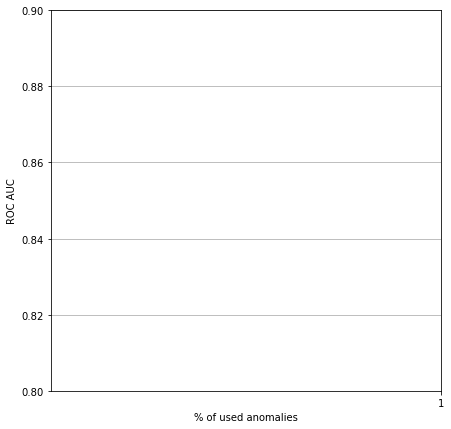

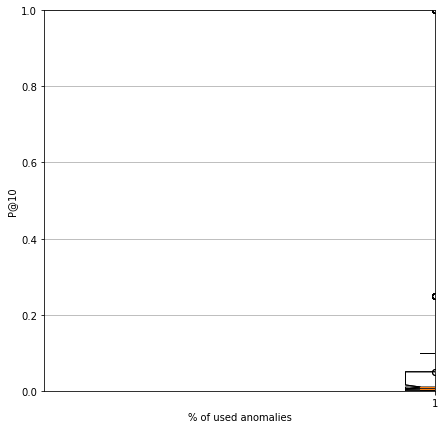

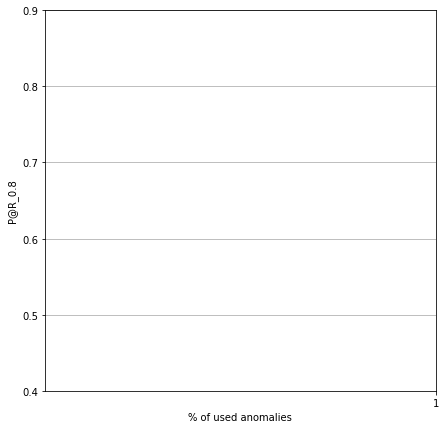

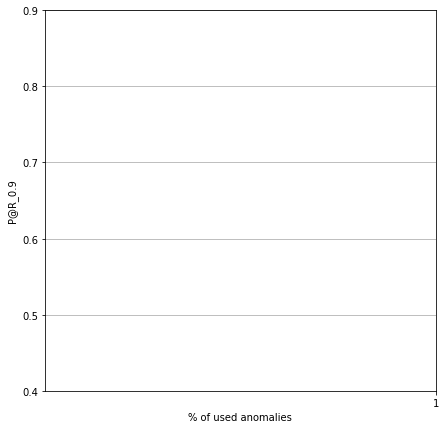

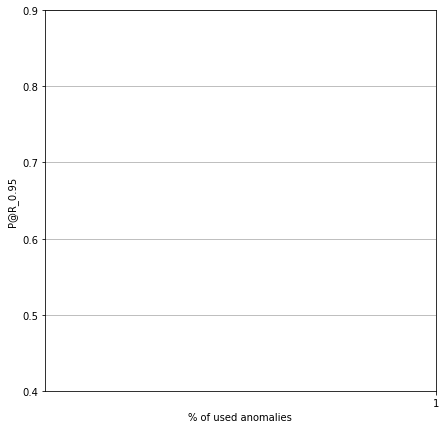

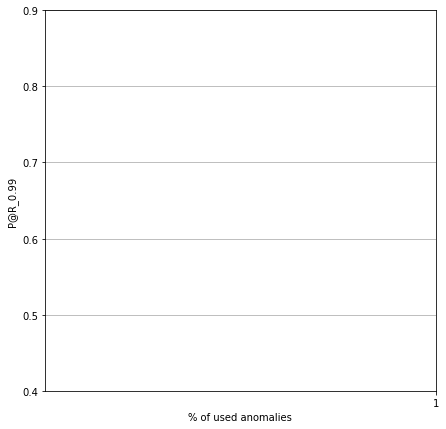



  8%|▊         | 2/25 [05:14<1:00:40, 158.30s/it]

In [ ]:
%%time
metrics_path = './metrics/xgb'
for (clf_name, clf) in tqdm(classifiers_classic_sup.items()):
    for i, (frac, n_resplit) in tqdm(enumerate(zip(fraction_of_negative_used, n_resplits))):
        if frac > 1:
            end_ind = X_bad.shape[0]
        else:   
            end_ind = int(X_bad.shape[0] * frac)
            
        for j in tqdm(range(n_resplit)):
            idx = np.random.permutation(X_bad.shape[0])
            clf.fit(np.concatenate((X_good, X_bad[idx[:end_ind]])), 
                    np.concatenate((np.zeros((X_good.shape[0],1)), np.ones((end_ind,1)))).ravel()) 
            y_pred = clf.predict_proba(X_test)[:,1]
            if clf_name in supervised_pr_aucs:
                # append the new number to the existing array at this slot
                supervised_pr_aucs[clf_name].append((frac, average_precision_score(y_test, y_pred)))
                supervised_roc_aucs[clf_name].append((frac, roc_auc_score(y_test, y_pred)))
                supervised_p_at_10[clf_name].append((frac, p_at_10_un(y_test, y_pred)))
            else:
                # create a new array in this slot
                supervised_pr_aucs[clf_name] = [(frac, average_precision_score(y_test, y_pred))]
                supervised_roc_aucs[clf_name] = [(frac, roc_auc_score(y_test, y_pred))]
                supervised_p_at_10[clf_name] = [(frac, p_at_10_un(y_test, y_pred))]
            _eval_p_at_rs(y_test, y_pred, frac, supervised_p_at_r, descr=clf_name)

            # plot metrics
            display.clear_output(wait=True)
            plot_for_comparison(supervised_pr_aucs, supervised_pr_aucs.keys(), ylabel="PR AUC", y_lim=(0.8, 0.9))
            plot_for_comparison(supervised_roc_aucs, supervised_roc_aucs.keys(), ylabel="ROC AUC", y_lim=(0.8, 0.9))
            plot_for_comparison(supervised_p_at_10, supervised_p_at_10.keys(), ylabel="P@10", y_lim=(0., 1))
            for key in supervised_p_at_r.keys():
                plot_for_comparison(supervised_p_at_r[key], supervised_p_at_r[key].keys(), 
                                    ylabel="P@R_" + str(key), y_lim=(0.4, 0.9))
            
            if j % 5 == 0:
                dump_metrics(metrics_path)
        dump_metrics(metrics_path)